## 4. pipeline modelling

### 4.1 develop function for classification model development, evaluation and parameter optimization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [21]:
#optimize the hyperparameters in classification algorithms
def classification_tune(clf_estimator, param_grid, X_train, y_train, X_test, y_test):
    ##find the best model
    clf_random = RandomizedSearchCV(estimator = clf_estimator, param_distributions=param_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
    clf_random.fit(X_train, y_train)
    best_clf=clf_random.best_estimator_
    y_pred=best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test_s)[::,1]
    print("BEST PARAMS", clf_random.best_params_)
    return best_clf, y_pred, y_pred_proba 

In [22]:
#evaluation of the classification models
def classification_eval(best_clf, y_test, y_pred, y_pred_proba):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g', ax=ax1)
    plt.tight_layout()
    ax1.set_title('Confusion matrix')
    ax1.set_ylabel('Actual label')
    ax1.set_xlabel('Predicted label')
    print("Accuracy:",accuracy_score(y_test, y_pred).round(3))
    print("Precision:",precision_score(y_test, y_pred).round(3))
    print("Recall:",recall_score(y_test, y_pred).round(3))
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba).round(3)
    ax2.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    return ax1, ax2 
    

In [23]:
#find the importance of features
def feature_importance(best_clf):
    fea_importance=dict(zip(features_name, np.round(best_clf.feature_importances_, 2)))
    sort_fea_importance={}
    sorted_keys = sorted(fea_importance, key=fea_importance.get)
    for i in sorted_keys:
        sort_fea_importance[i]=fea_importance[i]
    return sort_fea_importance

### 4.2 import df_sum related files

Q: Can we develop better model using df_sum instead of df_new??

In [24]:
file='data/df_sum.csv'
df=pd.read_csv(file)

In [25]:
features_name=df.drop(columns=['DEFAULT', 'ID']).columns
features_name

Index(['LIMIT_BAL', 'SEX_2', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'MARRIAGE_2', 'MARRIAGE_3', 'AGE', 'pay_sum', 'utilization_ratio_mean',
       'bill_trend', 'bill_sum', 'pay_trend', 'payment_sum',
       'payment_ratio_mean', 'loss_given_default'],
      dtype='object')

In [26]:
from numpy import loadtxt
X_train_s = loadtxt('data/X2_train_s.csv', delimiter=',')
X_test_s = loadtxt('data/X2_test_s.csv', delimiter=',')
y_train = loadtxt('data/y2_train.csv', delimiter=',')
y_test = loadtxt('data/y2_test.csv', delimiter=',')

### 4.3 Model development
#### 4.3.1 Regularized logistic regression

In [27]:
param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}
clf_estimator = LogisticRegression()
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train, X_test_s, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS {'C': 0.05}


Accuracy: 0.727
Precision: 0.733
Recall: 0.716


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

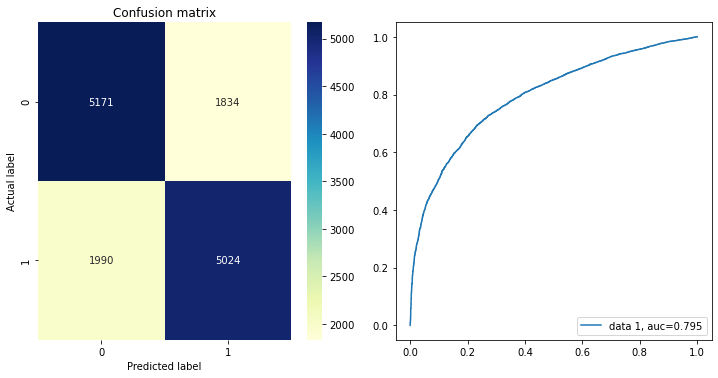

In [28]:
classification_eval(best_clf, y_test, y_pred, y_pred_proba)

In [29]:
from sklearn.feature_selection import SelectFromModel
sfm=SelectFromModel(best_clf, threshold=-np.inf, max_features=5)
sfm.fit(X_train_s, y_train)
feature_idx=sfm.get_support()
feature_name=features_name[feature_idx]
feature_name

Index(['SEX_2', 'EDUCATION_2', 'EDUCATION_3', 'MARRIAGE_2', 'pay_sum'], dtype='object')

#### 4.3.2 Decision tree

In [30]:
from sklearn.tree import export_graphviz
import graphviz 
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth':[2,4,6,8,10,12]}
clf_estimator = DecisionTreeClassifier()
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train, X_test_s, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS {'max_depth': 10, 'criterion': 'gini'}


Accuracy: 0.756
Precision: 0.77
Recall: 0.73


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

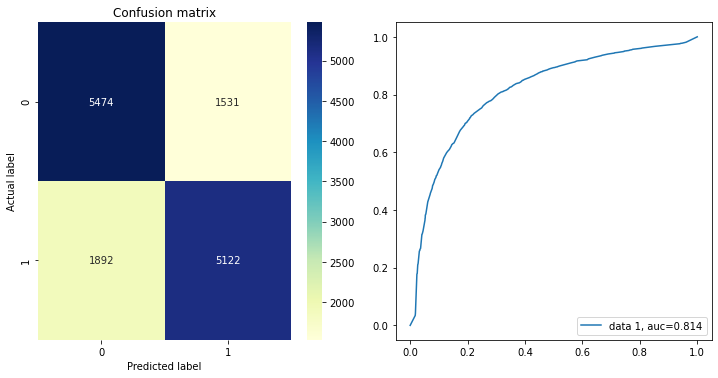

In [31]:
classification_eval(best_clf, y_test, y_pred, y_pred_proba)

In [32]:
feature_importance(best_clf)

{'MARRIAGE_3': 0.0,
 'EDUCATION_4': 0.01,
 'loss_given_default': 0.02,
 'utilization_ratio_mean': 0.03,
 'bill_trend': 0.03,
 'pay_trend': 0.03,
 'payment_ratio_mean': 0.03,
 'EDUCATION_3': 0.04,
 'AGE': 0.04,
 'bill_sum': 0.04,
 'LIMIT_BAL': 0.05,
 'SEX_2': 0.05,
 'EDUCATION_2': 0.05,
 'MARRIAGE_2': 0.06,
 'payment_sum': 0.09,
 'pay_sum': 0.42}

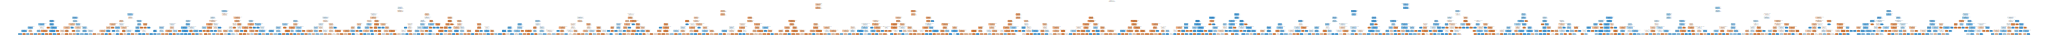

In [33]:
dot_data = export_graphviz(best_clf, out_file = None, feature_names = features_name, filled = True, rounded = True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

#### 4.3.3 Random forest

In [34]:
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
param_grid = {'n_estimators': n_estimators, 'max_depth':max_depths}
clf_estimator = RandomForestClassifier()
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train, X_test_s, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS {'n_estimators': 200, 'max_depth': 9}


Accuracy: 0.773
Precision: 0.784
Recall: 0.754


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

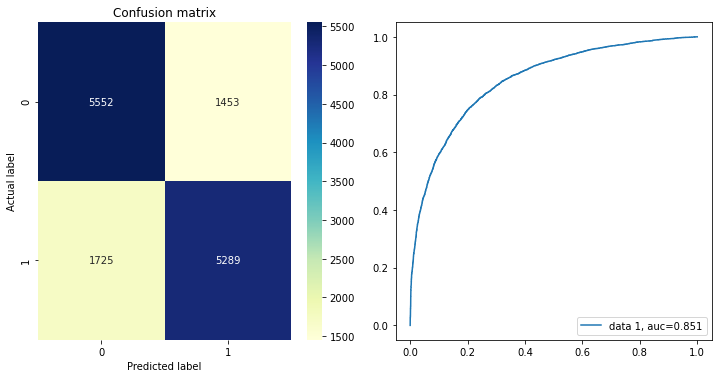

In [35]:
classification_eval(best_clf, y_test, y_pred, y_pred_proba)

In [36]:
feature_importance(best_clf)

{'EDUCATION_4': 0.0,
 'MARRIAGE_3': 0.0,
 'EDUCATION_3': 0.03,
 'AGE': 0.03,
 'pay_trend': 0.03,
 'payment_ratio_mean': 0.03,
 'loss_given_default': 0.03,
 'EDUCATION_2': 0.04,
 'bill_trend': 0.04,
 'utilization_ratio_mean': 0.05,
 'bill_sum': 0.05,
 'LIMIT_BAL': 0.06,
 'SEX_2': 0.07,
 'MARRIAGE_2': 0.08,
 'payment_sum': 0.08,
 'pay_sum': 0.37}

#### 4.3.4 Gradient boosting

In [37]:
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
param_grid = {'n_estimators': n_estimators, 'max_depth':max_depths, 'learning_rate': learning_rates}
clf_estimator = GradientBoostingClassifier()
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train, X_test_s, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.25}


Accuracy: 0.827
Precision: 0.829
Recall: 0.825


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

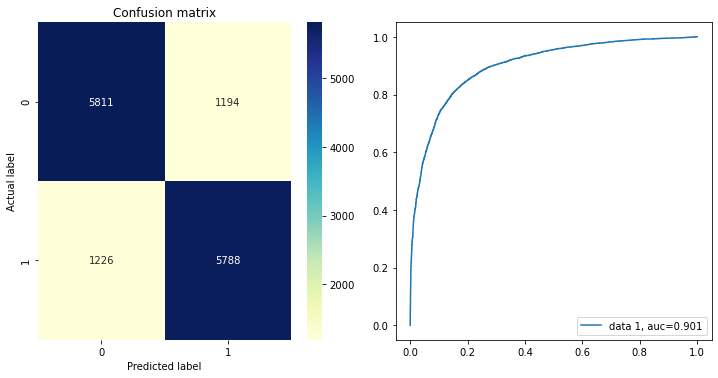

In [38]:
classification_eval(best_clf, y_test, y_pred, y_pred_proba)

In [39]:
feature_importance(best_clf)

{'MARRIAGE_3': 0.0,
 'EDUCATION_4': 0.01,
 'EDUCATION_3': 0.02,
 'SEX_2': 0.03,
 'EDUCATION_2': 0.03,
 'MARRIAGE_2': 0.04,
 'AGE': 0.06,
 'payment_ratio_mean': 0.06,
 'loss_given_default': 0.06,
 'LIMIT_BAL': 0.07,
 'utilization_ratio_mean': 0.07,
 'bill_trend': 0.07,
 'bill_sum': 0.07,
 'pay_trend': 0.07,
 'payment_sum': 0.09,
 'pay_sum': 0.25}

#### 4.3.5 Extreme Gradient Boosting (XGBoost)

In [40]:
gammas=[0.1, 0.2, 0.3, 0.4, 0.5]
subsamples=[0.5, 0.6, 0.7, 0.8]
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
param_grid = {'gamma':gammas, 'subsample': subsamples, 'n_estimators': n_estimators, 'max_depth':max_depths, 'learning_rate': learning_rates}
clf_estimator=XGBClassifier(use_label_encoder=False)
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train, X_test_s, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[18:05:27] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
BEST PARAMS {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.3}


Accuracy: 0.826
Precision: 0.829
Recall: 0.82


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

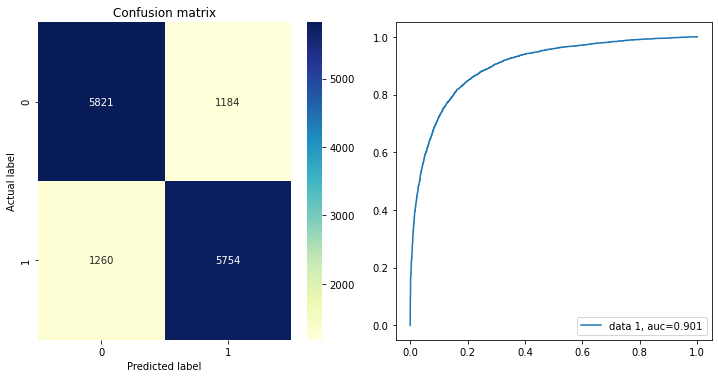

In [41]:
classification_eval(best_clf, y_test, y_pred, y_pred_proba)

In [42]:
feature_importance(best_clf)

{'AGE': 0.03,
 'utilization_ratio_mean': 0.03,
 'bill_trend': 0.03,
 'pay_trend': 0.03,
 'payment_ratio_mean': 0.03,
 'loss_given_default': 0.03,
 'LIMIT_BAL': 0.04,
 'bill_sum': 0.04,
 'payment_sum': 0.04,
 'MARRIAGE_3': 0.05,
 'EDUCATION_2': 0.08,
 'SEX_2': 0.1,
 'EDUCATION_3': 0.1,
 'EDUCATION_4': 0.1,
 'MARRIAGE_2': 0.13,
 'pay_sum': 0.16}

#### 4.3.6 KNN

In [43]:
n_neighbors = [50, 100, 500, 1000, 5000]
p=[1,2]
param_grid ={'n_neighbors':n_neighbors, 'p':p}
clf_estimator=KNeighborsClassifier()
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train, X_test_s, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS {'p': 1, 'n_neighbors': 50}


Accuracy: 0.754
Precision: 0.772
Recall: 0.72


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

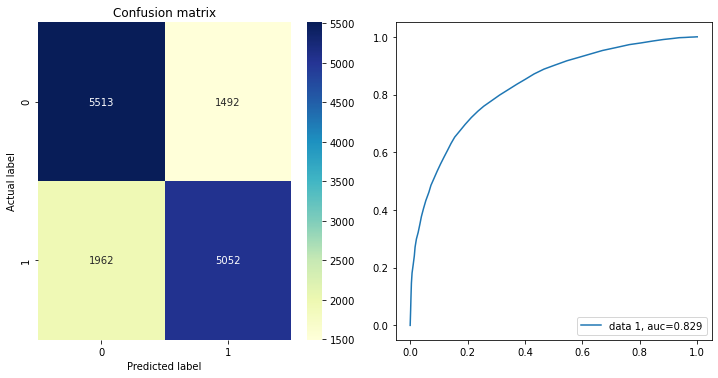

In [44]:
classification_eval(best_clf, y_test, y_pred, y_pred_proba)

In [46]:
from sklearn.model_selection import cross_val_score
n_feats = X_train_s.shape[1]
print('Feature  Accuracy')
for i in range(n_feats):
    X = X_train_s[:, i].reshape(-1, 1)
    scores = cross_val_score(best_clf, X, y_train, cv=5)
    print(f'{i}        {scores.mean():g}')

Feature  Accuracy
0        0.640343
1        0.609771
2        0.486472
3        0.508147
4        0.501513
5        0.587114
6        0.500841
7        0.504999
8        0.707787
9        0.571647
10        0.581797
11        0.546639
12        0.597541
13        0.592711
14        0.501452
15        0.54138


In [47]:
print(features_name[0], features_name[8])

LIMIT_BAL pay_sum


### 4.4 summary

1. We get pretty comparable model results using the smaller data set, df_sum, with our engineered features
2. XGBoost and gradient boosting gave us the best model with AOC value 0.901, followed by random forest, and then the other more traditional algorithms.
3. The most critical feature in these models is pay_sum. It is an index to show the accumulated payment behavior, on time, or delay. Besides pay_sum, different models gave us different important features.